# Prepare for colab

In [1]:
!pip install xgboost -U
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 192.9 MB 50 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Upload API Token

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/backups/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


## Download and unzip dataset

In [3]:
!kaggle datasets download -d ryuina/amex-fe-plus
!unzip /content/amex-fe-plus.zip

100% 3.55G/3.56G [00:38<00:00, 116MB/s]
100% 3.56G/3.56G [00:38<00:00, 98.9MB/s]
Archive:  /content/amex-fe-plus.zip
  inflating: test_fe_plus_plus.parquet  
  inflating: train_fe_plus_plus.parquet  


In [4]:
!kaggle competitions download -c amex-default-prediction -f sample_submission.csv
!unzip /content/sample_submission.csv.zip

 65% 21.0M/32.4M [00:00<00:00, 62.8MB/s]
100% 32.4M/32.4M [00:00<00:00, 68.5MB/s]
Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   


In [5]:
!kaggle competitions download -c amex-default-prediction -f train_labels.csv
!unzip /content/train_labels.csv.zip

 31% 5.00M/16.2M [00:00<00:01, 8.40MB/s]
100% 16.2M/16.2M [00:00<00:00, 25.1MB/s]
Archive:  /content/train_labels.csv.zip
  inflating: train_labels.csv        


# Training

In [6]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot
import os
import gc; gc.enable()

from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [7]:
VER=14
SEED = 42
FOLDS = 5

cat_features = ["B_30", "B_38", "D_114", "D_116", "D_117", "D_120", "D_126", "D_63", "D_64", "D_66", "D_68"]

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(SEED)

In [8]:
train = pd.read_parquet("/content/train_fe_plus_plus.parquet")
# train = train.reset_index(level=0)

In [9]:
# https://www.kaggle.com/code/ragnar123/amex-lgbm-dart-cv-0-7963
# Round last float features to 2 decimal place
float_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
float_cols = [col for col in float_cols if 'last' in col]

for col in float_cols:
    train[col + '_round'] = train[col].round(2)

num_cols = [col for col in train.columns if 'last' in col]
num_cols = [col[:-5] for col in num_cols if 'round' not in col]
for col in num_cols:
    try:
        train[f'{col}_last_mean'] = train[f'{col}_last'] - train[f'{col}_mean']
        # train[f'{col}_last_mean_div'] = train[f'{col}_last'] / train[f'{col}_mean']
        # train[f'{col}_mean-min'] = train[f'{col}_mean'] - train[f'{col}_min']
        # train[f'{col}_max-last'] = train[f'{col}_max'] - train[f'{col}_last']
    except: pass
num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)

for col in tqdm(num_cols):
    train[col] = train[col].astype(np.float16)

for col in train.columns:
    train[col] = train[col].replace([np.nan, np.inf, -np.inf], -127)

100%|██████████| 1713/1713 [04:50<00:00,  5.90it/s] 


In [10]:
train = train.set_index('customer_ID')
train = train.sort_index().reset_index()
FEATURES = train.drop(columns=['customer_ID', 'target']).columns
print(f"We have {len(FEATURES)} features")

We have 2177 features


In [11]:
# LOAD XGB LIBRARY
from sklearn.model_selection import KFold
import xgboost as xgb
print('XGB Version',xgb.__version__)

# XGB MODEL PARAMETERS
xgb_parms = {
    'max_depth':7,
    'eta':0.01,
    'subsample':0.75,
    'colsample_bytree':0.35,
    'min_child_weight':8,
    # 'booster': 'dart',
#     'max_delta_step': 16,
    'eval_metric':['logloss', 'auc'],
    'gamma':1.5,
    'lambda':70,
#     'reg_alpha':2,
#     'reg_lambda':2,
#     'scale_pos_weight':2.5,
#     'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':SEED
}

XGB Version 1.6.1


In [12]:
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
import numpy as np

def amex_metric_numpy(y_true: np.array, y_pred: np.array) -> float:

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting by descring prediction values
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

def xgb_amex(y_pred, y_true):
    return 'amex', amex_metric_numpy(y_true.get_label(), y_pred)

In [13]:
importances = []
oof = []
gc.collect()

skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold,(train_idx, valid_idx) in enumerate(skf.split(train, train.target )):
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print('#'*25)
    
    # TRAIN, VALID, TEST FOR FOLD K
    y_valid = train.loc[valid_idx, 'target']

    dtrain = xgb.DMatrix(data=train.loc[train_idx, FEATURES], label=train.loc[train_idx, 'target'])
    dvalid = xgb.DMatrix(data=train.loc[valid_idx, FEATURES], label=y_valid)

    # TRAIN MODEL FOLD K
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'eval')],
                num_boost_round=15000,
                early_stopping_rounds=800,
                maximize=True,
                custom_metric= xgb_amex,
                verbose_eval=500) 
    model.save_model(f'XGB_v{VER}_fold{fold}.xgb')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df)
            
    # INFER OOF FOLD K
    oof_preds = model.predict(dvalid)
    acc = amex_metric_numpy(y_valid.values, oof_preds)
    print('Kaggle Metric =',acc,'\n')
    
    # SAVE OOF
    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_pred'] = oof_preds
    oof.append( df )

    del dtrain, dd, df
    del y_valid, dvalid, model
    _ = gc.collect()
    
print('#'*25)
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_numpy(oof.target.values, oof.oof_pred.values)
print('OVERALL CV Kaggle Metric =',acc)

#########################
### Fold 1
### Train size 367130 Valid size 91783
#########################
[0]	train-logloss:0.68663	train-auc:0.93587	train-amex:0.70400	eval-logloss:0.68665	eval-auc:0.93316	eval-amex:0.69926
[500]	train-logloss:0.22218	train-auc:0.96145	train-amex:0.79206	eval-logloss:0.23097	eval-auc:0.95714	eval-amex:0.77795
[1000]	train-logloss:0.20620	train-auc:0.96618	train-amex:0.81396	eval-logloss:0.22186	eval-auc:0.95980	eval-amex:0.78712
[1500]	train-logloss:0.19705	train-auc:0.96928	train-amex:0.82818	eval-logloss:0.21908	eval-auc:0.96076	eval-amex:0.79036
[2000]	train-logloss:0.18985	train-auc:0.97175	train-amex:0.84002	eval-logloss:0.21780	eval-auc:0.96122	eval-amex:0.79253
[2500]	train-logloss:0.18331	train-auc:0.97399	train-amex:0.85185	eval-logloss:0.21705	eval-auc:0.96149	eval-amex:0.79319
[3000]	train-logloss:0.17728	train-auc:0.97604	train-amex:0.86289	eval-logloss:0.21656	eval-auc:0.96167	eval-amex:0.79471
[3500]	train-logloss:0.17149	train-auc:0.97798	t

In [14]:
# CLEAN RAM
del train
_ = gc.collect()

In [15]:
import matplotlib.pyplot as plt

df = importances[0].copy()
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
df.to_csv(f'xgb_feature_importance_v{VER}.csv',index=False)

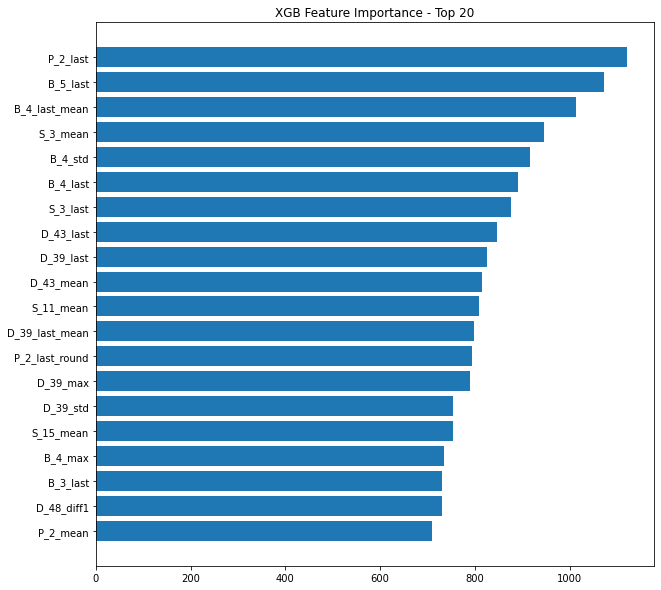

In [16]:
NUM_FEATURES = 20
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB Feature Importance - Top {NUM_FEATURES}')
plt.show()

# Test part

In [17]:
# CALCULATE SIZE OF EACH SEPARATE TEST PART
def get_rows(customers, test, NUM_PARTS = 4, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

In [18]:
# COMPUTE SIZE OF 4 PARTS FOR TEST DATA
NUM_PARTS = 4

test = pd.read_parquet("/content/test_fe_plus_plus.parquet")

customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')

We will process test data as 4 separate parts.
There will be 231155 customers in each part (except the last part).
Below are number of rows in each part:
[231155, 231155, 231155, 231156]


In [19]:
# INFER TEST DATA IN PARTS
skip_rows = 0
skip_cust = 0
test_preds = []

for k in range(NUM_PARTS):
    # READ PART OF TEST DATA
    print(f'\nReading test data...')
    test_copy = test.iloc[skip_rows:skip_rows+rows[k]].copy()
    test_copy = test_copy.set_index('customer_ID')
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test_copy.shape )

    for col in float_cols:
        test_copy[col + '_round'] = test_copy[col].round(2)

    num_cols = [col for col in test_copy.columns if 'last' in col]
    num_cols = [col[:-5] for col in num_cols if 'round' not in col]
    for col in num_cols:
        try:
            test_copy[f'{col}_last_mean'] = test_copy[f'{col}_last'] - test_copy[f'{col}_mean']
            # test_copy[f'{col}_last_mean_div'] = test_copy[f'{col}_last'] / test_copy[f'{col}_mean']
            # test_copy[f'{col}_mean-min'] = test_copy[f'{col}_mean'] - test_copy[f'{col}_min']
            # test_copy[f'{col}_max-last'] = test_copy[f'{col}_max'] - test_copy[f'{col}_last']
        except: pass
    num_cols = list(test_copy.dtypes[(test_copy.dtypes == 'float32') | (test_copy.dtypes == 'float64')].index)

    for col in tqdm(num_cols):
        test_copy[col] = test_copy[col].astype(np.float16)

    test_copy.replace([np.nan, np.inf, -np.inf], -127, inplace=True)

    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    if k==NUM_PARTS-1: test_copy = test_copy.loc[customers[skip_cust:]]
    else: test_copy = test_copy.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust
    
    # TEST DATA FOR XGB
    X_test = test_copy[FEATURES]
    dtest = xgb.DMatrix(data=X_test)
    test_copy = test_copy[['P_2_mean']] # reduce memory
    del X_test
    gc.collect()

    # INFER XGB MODELS ON TEST DATA
    model = xgb.Booster()
    model.load_model(f'XGB_v{VER}_fold0.xgb')
    preds = model.predict(dtest)
    for f in range(1,FOLDS):
        model.load_model(f'XGB_v{VER}_fold{f}.xgb')
        preds += model.predict(dtest)
    preds /= FOLDS
    test_preds.append(preds)

    # CLEAN MEMORY
    del test_copy, dtest, model
    _ = gc.collect()

del test
_ = gc.collect()


Reading test data...
=> Test part 1 has shape (231155, 1637)


100%|██████████| 1713/1713 [00:10<00:00, 164.24it/s]



Reading test data...
=> Test part 2 has shape (231155, 1637)


100%|██████████| 1713/1713 [00:10<00:00, 159.79it/s]



Reading test data...
=> Test part 3 has shape (231155, 1637)


100%|██████████| 1713/1713 [00:10<00:00, 156.56it/s]



Reading test data...
=> Test part 4 has shape (231156, 1637)


100%|██████████| 1713/1713 [00:10<00:00, 160.29it/s]


In [20]:
# WRITE SUBMISSION FILE
test = pd.DataFrame(index=customers,data={'prediction': np.concatenate(test_preds)})
sub = pd.read_csv('/content/sample_submission.csv')[['customer_ID']]
sub['customer_ID_hash'] = sub['customer_ID'].copy()
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

# DISPLAY PREDICTIONS
sub.to_csv(f'submission_xgb_v{VER}_seed{SEED}_fold{FOLDS}.csv',index=False)
print('Submission file shape is', sub.shape )
sub.head()

Submission file shape is (924621, 2)


,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.028127
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000726
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.038345
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.251165
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.890721


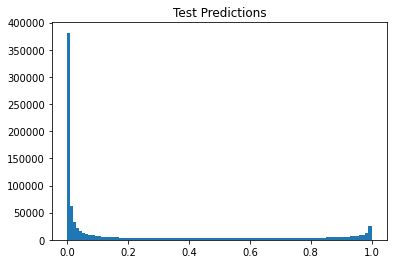

In [21]:
# PLOT PREDICTIONS
import matplotlib.pyplot as plt

plt.hist(sub.prediction, bins=100)
plt.title('Test Predictions')
plt.show()

# Submit to Kaggle from Colab

In [22]:
# Submit
!kaggle competitions submit -c amex-default-prediction -f submission_xgb_v14_seed42_fold5.csv -m "Run with Risk binaries seed 42 fold 5"

100% 67.6M/67.6M [00:03<00:00, 18.4MB/s]
400 - Bad Request


In [23]:
# Run after few seconds
!kaggle competitions submissions amex-default-prediction

fileName                             date                 description                                                       status    publicScore  privateScore  
-----------------------------------  -------------------  ----------------------------------------------------------------  --------  -----------  ------------  
Amex Default Prediction - Ensemble   2022-08-17 09:55:30  Notebook Amex Default Prediction - Ensemble | Version 81          complete  0.798                      
Amex Default Prediction - Ensemble   2022-08-17 09:52:14  Notebook Amex Default Prediction - Ensemble | Version 80          complete  0.799                      
Amex Default Prediction - Ensemble   2022-08-17 09:49:00  Notebook Amex Default Prediction - Ensemble | Version 79          complete  0.799                      
submission_lgb_v14_seed42_fold5.csv  2022-08-17 09:36:30  bruto and modified bin features. seed 52 fold 5 From colab        complete  0.798                      
submission_cat_v14_seed42_fo